In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import hodel.dismech as dismech_jax
from typing import Any

In [2]:
# Single triplet connectivity
conn = dismech_jax.Connectivity(
    dismech_jax.map_node_to_dof(jnp.array([[0, 1], [1, 2]])),
    jnp.array([3, 4]),
    jnp.array([[0, 1]]),
    jnp.array([[1, 1]]),
)


def get_state(seed: int = 42) -> dismech_jax.StaticState:
    x0 = jax.random.uniform(jax.random.key(seed), [11])
    return dismech_jax.StaticState.init(x0, conn)


def update_and_get_energy(triplet):
    def func(x, Theta, state0):
        state = state0.update(x, conn)
        return triplet.get_energy(state, Theta)

    return func


def get_random_der_triplet(
    state: dismech_jax.StaticState, seed: int = 42
) -> dismech_jax.DERTriplet:
    key = jax.random.key(seed)
    EA = jax.random.uniform(key, [1])
    EI = jax.random.uniform(key, [2])
    GJ = jax.random.uniform(key, [1])
    l_0 = jnp.linalg.norm(state.q[0:3] - state.q[3:6])
    l_1 = jnp.linalg.norm(state.q[3:6] - state.q[6:9])
    return dismech_jax.DERTriplet.init(
        dismech_jax.map_node_to_dof(jnp.array([0, 1, 2])),
        jnp.array([9, 10]),
        jnp.array([1.0, 1.0]),
        jnp.array([l_0, l_1]),
        jnp.array([0], dtype=jnp.int32),
        EA,
        EI,
        GJ,
        state,
    )


def test_energy_stretch_linear_elastic(
    triplet,
    state: dismech_jax.StaticState,
    seed: int = 10,
    Theta: Any = None,
    change: float = 1e-3,
):
    get_energy = update_and_get_energy(triplet)

    # Deformed state
    x = jax.random.uniform(jax.random.key(seed), [11])
    hess = jax.hessian(get_energy, 0)(x, Theta, state)
    energy_ground, grad = jax.value_and_grad(get_energy, 0)(x, Theta, state)

    # FDM
    grad_fdm = jnp.zeros_like(x)
    hess_fdm = jnp.zeros((x.shape[0], x.shape[0]))

    for c in range(x.shape[0]):
        x_plus = x.at[c].add(change)

        energy_plus = get_energy(x_plus, Theta, state)
        grad_fdm = grad_fdm.at[c].set((energy_plus - energy_ground) / change)

        grad_change = jax.grad(get_energy, 0)(x_plus, Theta, state)
        hess_fdm = hess_fdm.at[:, c].set((grad_change - grad) / change)

    # Plot gradients
    plt.figure(1)
    plt.plot(grad, "ro", label="Analytical")
    plt.plot(grad_fdm, "b^", label="Finite Difference")
    plt.legend()
    plt.xlabel("Index")
    plt.ylabel("Gradient")
    plt.title("Forces (Gradients) Comparison")
    plt.show()

    # Plot Hessians
    plt.figure(2)
    plt.plot(hess.flatten(), "ro", label="Analytical")
    plt.plot(hess_fdm.flatten(), "b^", label="Finite Difference")
    plt.legend()
    plt.xlabel("Index")
    plt.ylabel("Hessian")
    plt.title("Hessian Comparison")
    plt.show()


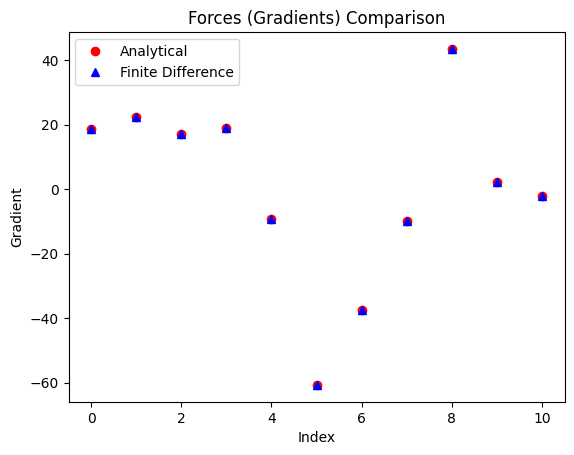

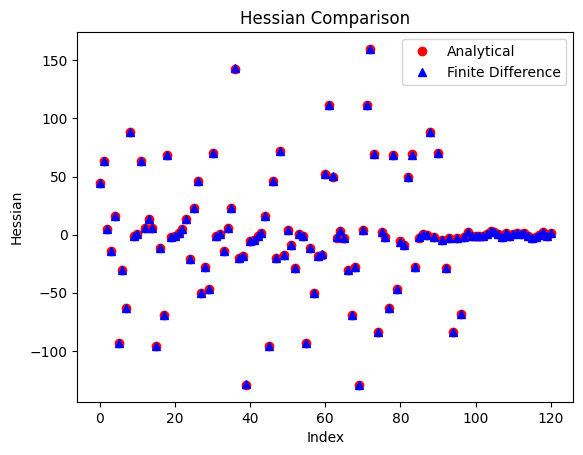

In [3]:
state = get_state()
test_energy_stretch_linear_elastic(get_random_der_triplet(state), state)

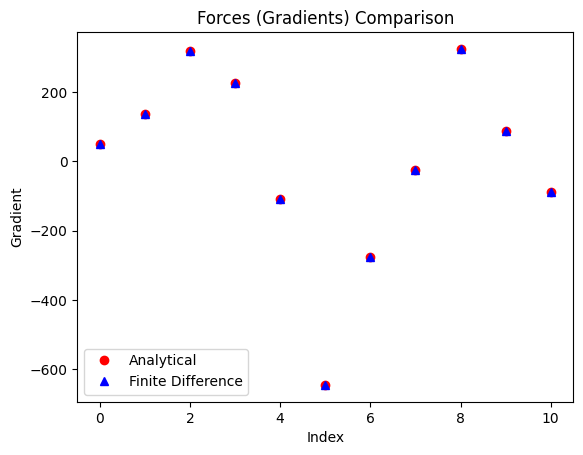

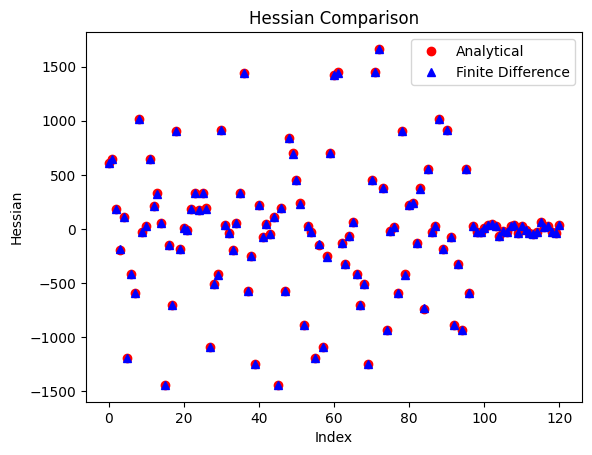

In [4]:
from dataclasses import dataclass
from jax.tree_util import register_dataclass
import flax.linen as nn
from typing import cast

def get_nn_triplet_cls():
    def vector_to_psd_matrix(values: jax.Array, n: int = 5) -> jax.Array:
        """Convert vector to PSD matrix via Cholesky."""
        L = jnp.zeros((n, n))
        tril_indices = jnp.tril_indices(n)
        L = L.at[tril_indices].set(values)
        
        # Ensure positive diagonal
        diag_indices = jnp.diag_indices(n)
        L = L.at[diag_indices].set(jax.nn.softplus(L[diag_indices]) + 1e-6)
        
        return L @ L.T
    
    class Model(nn.Module):
        dmid: int
        
        @nn.compact
        def __call__(self, x):
            x = nn.Dense(self.dmid)(x)
            x = nn.relu(x)
            x = nn.Dense(self.dmid)(x)
            x = nn.relu(x)
            # Output 15 values for 5x5 Cholesky factor
            values = nn.Dense(15)(x)
            # Convert to PSD matrix
            return vector_to_psd_matrix(values, n=5)
    
    model = Model(dmid=64)
    
    @register_dataclass
    @dataclass(frozen=True)
    class NNTriplet(dismech_jax.Triplet):
        
        @jax.jit
        def get_K(self, strain: jax.Array, params: dict) -> jax.Array:
            return cast(jax.Array, model.apply(params, strain))
    
    params = model.init(jax.random.PRNGKey(4), jnp.zeros(5))
    return NNTriplet, params

MyTriplet, params = get_nn_triplet_cls()

def get_random_my_triplet(state: dismech_jax.StaticState):
    l_0 = jnp.linalg.norm(state.q[0:3] - state.q[3:6])
    l_1 = jnp.linalg.norm(state.q[3:6] - state.q[6:9])
    return MyTriplet.init(
        dismech_jax.map_node_to_dof(jnp.array([0,1,2])),
        jnp.array([9,10]),
        jnp.array([1.0, 1.0]),
        jnp.array([l_0, l_1]),
        jnp.array([0]),
        state,
    )


test_energy_stretch_linear_elastic(get_random_my_triplet(state), 
                                   state, 
                                   Theta=params)